# Check LAI resolutions
For averaging to monthly, we need to know that the resolution and GeoTIFF dimensions are the same for all 7-day files.

Findings:
- MODIS LAI does not have spatially consistent data fields
- Any day in December as well as Jan-01 cover less ground in the latitude direction
- There are 2 further discrepencies we haven't looked into yet

Procedure:
- Move processing tasks to Windows machine, because on macos we run into problems with HDF4 & GDAL - compiling GDAL with HDF4 support is tricky

Solution:
- Doubling up on domain specification in both `gdal.Warp` and `gdal.Translate` seems to lead to spatially consistent data fields
- See function `process_daily_modis_hdf_to_tif` in `geospatial.py` that's part of the CAMELS-SPAT code

Re-run:
- LAI download code to get daily files covering North America
- Move these files to Copernicus, as well as mac
- Re-do the CAMELS-SPAT processing of LAI data


In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import _functions as pmf

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [3]:
# Get the required info from the config file
raw_path = pmf.read_from_config(config_file,'raw_path')

### 1. Find LAI files

In [4]:
import glob

In [5]:
src_path = Path(raw_path) / 'lai' / 'raw'

In [10]:
lai_files = sorted( glob.glob(str(src_path / '*.tif')) )

In [11]:
len(lai_files)

982

### 2. Extract file properties

In [12]:
import os
import rasterio

In [13]:
def get_geotiff_properties(file):

    with rasterio.open(file) as src:
        geoTransform = src.transform
        pixelSize = [geoTransform[0],geoTransform[4]]
        rasterSize = [src.width,src.height]
        boundingBox = src.bounds
    
    return pixelSize, rasterSize, boundingBox

In [14]:
def get_date_from_filename(file):
    file_name = os.path.basename(file)
    yyyymmdd = file_name[0:8]
    return yyyymmdd

In [15]:
x_res = []
y_res = []
x_size= []
y_size= []
b_box = []
dates = []

In [16]:
for file in lai_files:
    px,rs,bb = get_geotiff_properties(file)
    date = get_date_from_filename(file)
    x_res.append(px[0])
    y_res.append(px[1])
    x_size.append(rs[0])
    y_size.append(rs[1])
    b_box.append(bb)
    dates.append(date)

### 3. Analysis

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
data_dict = {'x_resolution': x_res, 'y_resolution': y_res, 
             'x_raster_size': x_size, 'y_raster_size': y_size, 'bounding_box': b_box}

In [19]:
data = pd.DataFrame(data_dict)

In [20]:
dti = pd.to_datetime(dates,format='%Y%m%d') # index
data = data.set_index(dti)

In [21]:
# Count occurrences of each unique value in each column
print(f'Checking {len(lai_files)} MODIS LAI files:\n')
for column in data.columns:
    value_counts = data[column].value_counts()
    print(f"Value counts in {column}:\n{value_counts}\n")

Checking 982 MODIS LAI files:

Value counts in x_resolution:
x_resolution
0.003836    981
0.004700      1
Name: count, dtype: int64

Value counts in y_resolution:
y_resolution
-0.003836    981
-0.004700      1
Name: count, dtype: int64

Value counts in x_raster_size:
x_raster_size
33757    981
27555      1
Name: count, dtype: int64

Value counts in y_raster_size:
y_raster_size
20854    981
17022      1
Name: count, dtype: int64

Value counts in bounding_box:
bounding_box
(-179.5, 5.0, -50.0, 85.0)    982
Name: count, dtype: int64



Text(0, 0.5, 'resolution in x direction [degrees]')

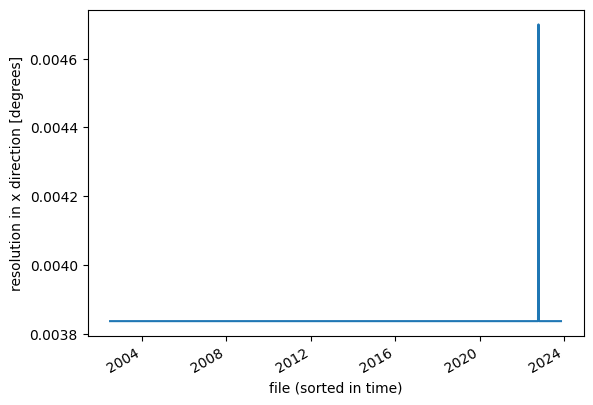

In [23]:
data['x_resolution'].plot()
plt.xlabel('file (sorted in time)')
plt.ylabel('resolution in x direction [degrees]')

In [24]:
for ix,row in data[data['x_raster_size'] == 27555].iterrows():
    print(ix)

2022-10-16 00:00:00


### 4. Download some raw data to see if the error originates there

In [94]:
from bs4 import BeautifulSoup
import os
from osgeo import gdal
import shutil
import re
import requests
from urllib.parse import urljoin

In [65]:
def find_files_in_webpage_folder(url, extension='.tif'):
    
    # Send an HTTP GET request to the URL and get the HTML content.
    response = requests.get(url)
    
    # Check if the request was successful (status code 200).
    if response.status_code == 200:
        # Parse the HTML content using BeautifulSoup.
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Grab any hrefs that have the correct extension
        #files = [a['href'] for a in soup.find_all('a', href=True) if extension in a['href']]
        files = [a['href'] for a in soup.find_all('a', href=True) if a['href'].endswith(extension)]
        
        # Convert relative URLs to absolute URLs.
        file_links = [urljoin(url, file) for file in files]
        
    else:
        print("Failed to retrieve the webpage. Status code:", response.status_code)        
    
    return file_links

In [60]:
def hdf_tile_in_north_america(url):

    '''Checks if a HDF URL falls within the North America domain (sort of).
       See Fig. 2 here: https://lpdaac.usgs.gov/documents/926/MOD15_User_Guide_V61.pdf'''

    # Separate parts
    file_name = os.path.basename(url)
    file_parts = file_name.split('.')

    # Check if this matches expectations
    pattern = r'h\d{2}v\d{2}'
    if not re.match(pattern,file_parts[2]):
        print('WARNING: hdf_tile_in_north_america(): URL {url} does not match expected pattern')
        return False

    # Check h and v values against what we want
    h = int(file_parts[2][1:3])
    v = int(file_parts[2][4:6])

    flag = True
    if h > 15: flag = False
    if v > 8:  flag = False
    if h < 7:  flag = False

    return flag

In [62]:
def download_modis_into_day_folder(download_folder, url):

    # Make the names and paths
    folder_name = os.path.basename(os.path.dirname(url))
    folder = download_folder/folder_name
    folder.mkdir(parents=True, exist_ok=True)
    
    # Check if this file is in the domain we want
    if hdf_tile_in_north_america(url):
        download_url_into_folder(url,folder)
    
    return folder

In [63]:
def download_url_into_folder(url,folder, retries_max=10, requests_kwargs={}, overwrite=False):
    
    # Extract the filename from the URL
    file_name = url.split('/')[-1].strip() # Get the last part of the url, strip whitespace and characters
    
    # Early exit
    if Path(folder/file_name).is_file():
        if not overwrite:
            print(f'File {folder/file_name} exists and download_url_into_folder() argument overwrite is False. Skipping file.')
            return
    
    # Make sure the connection is re-tried if it fails
    retries_cur = 1
    while retries_cur <= retries_max:
        try: 

            # Send a HTTP request to the server and save the HTTP response in a response object called response
            # kwargs:
            # - stream: (True/False) ensures that only response headers are downloaded initially 
            # - header: (dict)       specifies details about the request, such as User-Agent
            # - auth  : (tuple)      user name, password
            with requests.get(url.strip(), stream=True, **requests_kwargs) as response:

                # Decode the response
                response.raw.decode_content = True
                content = response.raw

                # Write to file
                with open(folder / file_name, 'wb') as data:
                    shutil.copyfileobj(content, data)
                    
                # print a completion message
                print('Successfully downloaded ' + url)
                    
        except Exception as e:
            print('Error downloading ' + url + ' on try ' + str(retries_cur) + ' with error: ' + str(e))
            retries_cur += 1
            continue
        else:
            break           
    
    return

In [89]:
def find_files_in_folder(folder,extension=''):

    '''Searches folder for files, optionally only those with specified extension'''

    files = glob.glob(f'{folder}/*{extension}')

    return files

In [98]:
def process_daily_modis_hdf_to_tif(in_folder, out_folder,
                                   subdataset_front='HDF4_EOS:EOS_GRID',
                                   subdataset_back='MOD_Grid_MOD15A2H:Lai_500m',
                                   to_CRS='EPSG:4326',
                                   subset_window=[]):

    # Find files
    files = find_files_in_folder(in_folder)

    # Transform to gdal.BuildVrt inputs, by specifying the subdataset we want
    hdf_inlist = [f'{subdataset_front}:"{file}":{subdataset_back}' for file in files if file.endswith('.hdf')]

    # Create a virtual dataset (VRT) of all individual GeoTIFF files that's not written to disk (argument '')
    vrt_options = gdal.BuildVRTOptions(resolution='highest')
    vrt = gdal.BuildVRT('', hdf_inlist, options=vrt_options)

    # Reproject the VRT
    warp_options = gdal.WarpOptions(format='VRT', dstSRS=to_CRS)
    vrt_4326 = gdal.Warp('', vrt, options=warp_options)

    # Subset and convert to geotiff
    if subset_window:
        tif_options = gdal.TranslateOptions(format='GTiff', projWin=subset_window, creationOptions=['COMPRESS=DEFLATE','BIGTIFF=YES'])
    else:
        tif_options = gdal.TranslateOptions(format='GTiff', creationOptions=['COMPRESS=DEFLATE','BIGTIFF=YES'])
    
    output_name = os.path.basename(in_folder).replace('.','') + '_' + subdataset_back.replace(':','_') + '.tif'
    gdal.Translate(str(out_folder/output_name), vrt_4326, options=tif_options).FlushCache()

    # Flush cache
    vrt = None
    vrt_4326 = None

#### Dev

In [101]:
files = find_files_in_folder(folder_dec)

In [104]:
hdf_inlist = files

In [105]:
vrt_options = gdal.BuildVRTOptions(resolution='highest')
vrt = gdal.BuildVRT('', hdf_inlist, options=vrt_options)

Warning 1: Can't open /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h09v05.061.2020084014805.hdf. Skipping it
Warning 1: Can't open /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h12v04.061.2020084012930.hdf. Skipping it
Warning 1: Can't open /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h12v03.061.2020084014803.hdf. Skipping it
Warning 1: Can't open /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h15v02.061.2020084014810.hdf. Skipping it
Warning 1: Can't open /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h09v08.061.2020084012926.hdf. Skipping it
Warning 1: Can't open /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h09v02.061.2020084012923.hdf. Skipping it
Warning 1: Can't open /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h11v07.061.2020084012930.hdf. Skipping it
Warning 1: Can't open /Users/wmk934/data/perceptual_models/tmp

#### Processing

In [66]:
folder_dec = 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.061/2002.12.03/'
folder_jul = 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.061/2002.07.04/'

In [80]:
tmp_path = Path( pmf.read_from_config(config_file,'temp_path') )

In [78]:
# December files
files_dec = find_files_in_webpage_folder(folder_dec, extension='.hdf')

In [91]:
for url in files_dec:
    folder_dec = download_modis_into_day_folder(tmp_path, url)

File /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h07v03.061.2020084012919.hdf exists and download_url_into_folder() argument overwrite is False. Skipping file.
File /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h07v05.061.2020084014743.hdf exists and download_url_into_folder() argument overwrite is False. Skipping file.
File /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h07v06.061.2020084012922.hdf exists and download_url_into_folder() argument overwrite is False. Skipping file.
File /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h07v07.061.2020084012919.hdf exists and download_url_into_folder() argument overwrite is False. Skipping file.
File /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h08v03.061.2020084012918.hdf exists and download_url_into_folder() argument overwrite is False. Skipping file.
File /Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A200

In [97]:
process_daily_modis_hdf_to_tif(folder_dec, tmp_path)

Warning 1: Can't open HDF4_EOS:EOS_GRID:"/Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h09v05.061.2020084014805.hdf":MCD_Grid_MCD15A2H:Lai_500m. Skipping it
Warning 1: Can't open HDF4_EOS:EOS_GRID:"/Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h12v04.061.2020084012930.hdf":MCD_Grid_MCD15A2H:Lai_500m. Skipping it
Warning 1: Can't open HDF4_EOS:EOS_GRID:"/Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h12v03.061.2020084014803.hdf":MCD_Grid_MCD15A2H:Lai_500m. Skipping it
Warning 1: Can't open HDF4_EOS:EOS_GRID:"/Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h15v02.061.2020084014810.hdf":MCD_Grid_MCD15A2H:Lai_500m. Skipping it
Warning 1: Can't open HDF4_EOS:EOS_GRID:"/Users/wmk934/data/perceptual_models/tmp/2002.12.03/MCD15A2H.A2002337.h09v08.061.2020084012926.hdf":MCD_Grid_MCD15A2H:Lai_500m. Skipping it
Warning 1: Can't open HDF4_EOS:EOS_GRID:"/Users/wmk934/data/perceptual_models/tmp/2002.12.03/MC

TypeError: object of wrong GDALDatasetShadow

In [87]:
# July files
files_jul = find_files_in_webpage_folder(folder_jul, extension='.hdf')
for url in files_jul:
    sub_folder = download_modis_into_day_folder(tmp_path, url)

Successfully downloaded https://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.061/2002.07.04/MCD15A2H.A2002185.h07v03.061.2020079150836.hdf
Successfully downloaded https://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.061/2002.07.04/MCD15A2H.A2002185.h07v05.061.2020079151404.hdf
Successfully downloaded https://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.061/2002.07.04/MCD15A2H.A2002185.h07v06.061.2020079151509.hdf
Successfully downloaded https://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.061/2002.07.04/MCD15A2H.A2002185.h07v07.061.2020079150859.hdf
Successfully downloaded https://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.061/2002.07.04/MCD15A2H.A2002185.h08v03.061.2020079152934.hdf
Successfully downloaded https://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.061/2002.07.04/MCD15A2H.A2002185.h08v04.061.2020079150215.hdf
Successfully downloaded https://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.061/2002.07.04/MCD15A2H.A2002185.h08v05.061.2020079150240.hdf
Successfully downloaded https://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.061/2002.07.04/MCD15A2H.A2002185.h08v0